# Laplacian Eigenmaps for Recurrence Matrices (LERM)

Here we reproduce the figures displaying the LERM analysis. The computations themselves were done on [CARC](https://www.carc.usc.edu/) machines. See [James et al. 2024](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2023PA004700) for details on the method, as well as information on how to run it yourself.

**Note:** This notebook assumes the existence of pickle files that need to have been created previously. If you are running this notebook on your machine, make sure you've successfully run both of the notebooks in the `Loading Data` folder.

In [1]:
import os
import pickle

import ammonyte as ammo
import pyleoclim as pyleo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.stats as stats
import matplotlib.transforms as transforms

from matplotlib.ticker import FormatStrFormatter
from pylipd.lipd import LiPD

In [2]:
with open('../../data/pickle/preprocessed_ens_dict.pkl', 'rb') as f:
    preprocessed_ens_dict = pickle.load(f)

with open('../../data/pickle/preprocessed_series_dict.pkl', 'rb') as f:
    preprocessed_series_dict = pickle.load(f)

In [3]:
# Sort by latitude

lat_dict = {series.lat:series.label for series in preprocessed_series_dict.values()}

sort_index = np.sort(np.array(list(lat_dict.keys())))[::-1]
sort_label = [lat_dict[lat] for lat in sort_index]
preprocessed_series_dict = {label:preprocessed_series_dict[label] for label in sort_label} #Sort by latitude

Loading pre-calculated lerm ensembles from CSV:

In [4]:
lerm_ens = {}
lerm_path = '../../data/CSV/lerm_ens/'

for key in preprocessed_ens_dict.keys():
    cave = key.split('.')[0]
    lerm_dir = os.path.join(lerm_path, cave)
    files = os.listdir(lerm_dir)
    series_list = []
    for file in files:
        num = file.split('_')[-1].split('.')[0]
        df = pd.read_csv(os.path.join(lerm_dir, file))
        series = pyleo.Series(
            time=df[f'age_{num}'].to_numpy(),
            value=df[f'value_{num}'].to_numpy(),
            time_name = 'age',
            time_unit = 'yr BP',
            value_name = 'FI',
            verbose=False
        )
        series_list.append(series)
        
    lerm_ens[key] = pyleo.EnsembleSeries(series_list)

Now we just plot up the results:

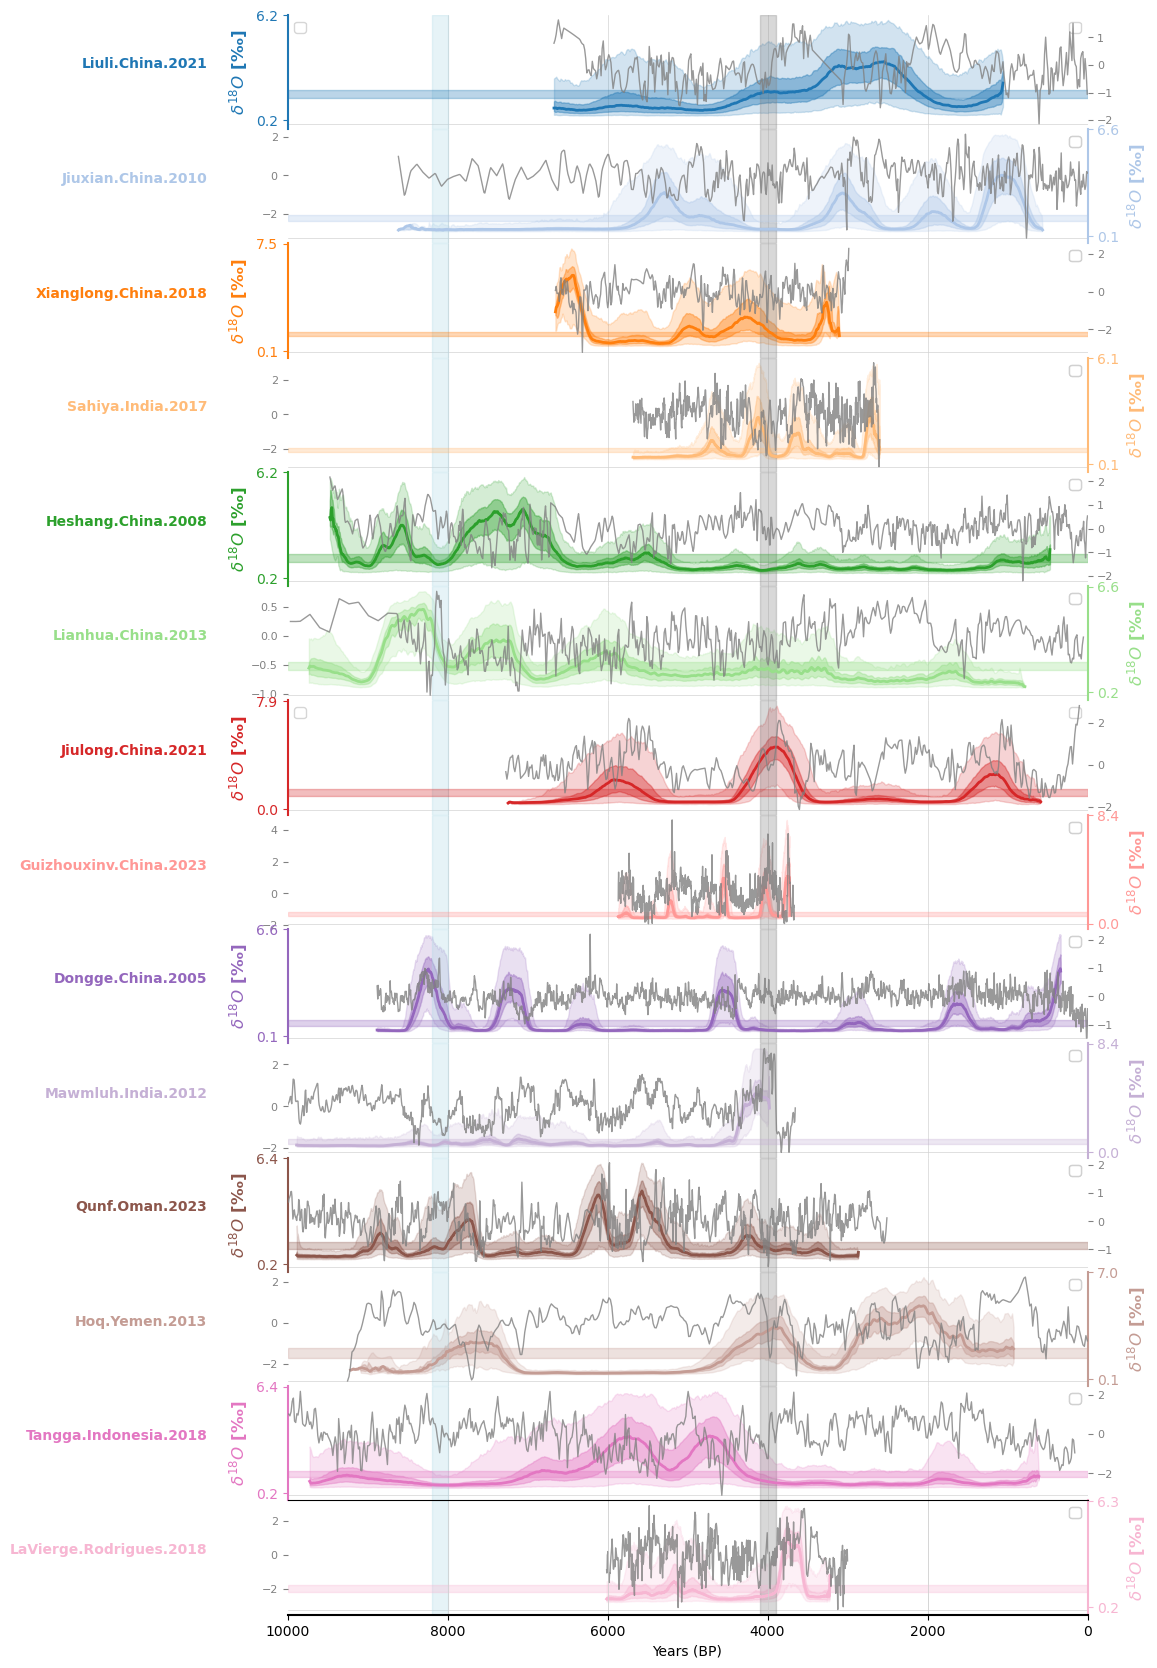

In [5]:
# Create a figure with a specified size
fig = plt.figure(figsize=(8, 16))

# Set up plot parameters
xlim = [0, 10000]
n_ts = len(preprocessed_ens_dict)
fill_between_alpha = 0.2
labels = 'auto'
ylabel_fontsize = 12
spine_lw = 1.5
grid_lw = 0.5
label_x_loc = -0.15
v_shift_factor = 1
linewidth = 1.5

ax = {}
left = 0
width = 1
height = 1 / n_ts
bottom = 1

colors = sns.color_palette('tab20',n_colors = len(preprocessed_ens_dict))

# Iterate over each pair in preprocessed_series_dict
for idx, pair in enumerate(preprocessed_series_dict.items()):
    label, series = pair
    ens = lerm_ens[label]

    # Calculate the median and confidence interval of the ensemble
    ens_median = ens.common_time().quantiles().series_list[1]
    upper, lower = ammo.utils.sampling.confidence_interval(ens_median)

    color = colors[idx]

    bottom -= height * v_shift_factor
    ax[idx] = fig.add_axes([left, bottom, width, height])

    # Plot the ensemble envelope
    ens.common_time(time_axis=preprocessed_series_dict[label].time, bounds_error=False).plot_envelope(ax=ax[idx], shade_clr=color, curve_clr=color)

    # Set plot properties for the main axis
    ax[idx].patch.set_alpha(0)
    ax[idx].set_xlim(xlim)
    time_label = 'Years (BP)'
    value_label = '$\delta^{18} O$ [‰]'
    ax[idx].set_ylabel(value_label, weight='bold', size=ylabel_fontsize)

    # Create a twin y-axis
    ax2 = ax[idx].twinx()
    ax2.grid(False)

    # Plot the series on the twin y-axis
    series.plot(ax=ax2, color='grey', alpha=.8, linestyle='-', linewidth=1, ylabel='')

    # Set y-axis limits and ticks for the main axis
    ylim = ax[idx].get_ylim()
    ax[idx].set_yticks([ylim[0], ylim[-1]])

    # Add labels to the plot
    trans = transforms.blended_transform_factory(ax[idx].transAxes, ax[idx].transData)
    ax[idx].text(-.1, np.mean(ylim), label, horizontalalignment='right', transform=trans, color=color, weight='bold')

    ax[idx].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[idx].grid(False)

    # Set spine and tick properties based on index
    if idx % 2 == 0:
        ax[idx].spines['left'].set_visible(True)
        ax[idx].spines['left'].set_linewidth(spine_lw)
        ax[idx].spines['left'].set_color(color)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].yaxis.set_label_position('left')
        ax[idx].yaxis.tick_left()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('right')
        ax2.yaxis.tick_right()
    else:
        ax[idx].spines['left'].set_visible(False)
        ax[idx].spines['right'].set_visible(True)
        ax[idx].spines['right'].set_linewidth(spine_lw)
        ax[idx].spines['right'].set_color(color)
        ax[idx].yaxis.set_label_position('right')
        ax[idx].yaxis.tick_right()
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.yaxis.set_label_position('left')
        ax2.yaxis.tick_left()

    # Set additional plot properties
    ax[idx].yaxis.label.set_color(color)
    ax[idx].tick_params(axis='y', colors=color)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].tick_params(axis='x', which='both', length=0)
    ax[idx].set_xlabel('')
    ax[idx].set_xticklabels([])
    ax[idx].legend([])
    xt = ax[idx].get_xticks()[1:-1]
    for x in xt:
        ax[idx].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].axhline(y=0, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
    ax[idx].invert_xaxis()

    # Highlight specific time spans
    ax[idx].axvspan(4100, 3900, color='grey', alpha=0.3)
    ax[idx].axvspan(8200, 8000, color='lightblue', alpha=0.3)

    # Highlight the confidence interval
    ax[idx].axhspan(upper, lower, color=color, alpha=.3)

    # Set properties for the twin y-axis
    ax2.tick_params(axis='y', colors='grey', labelsize=8)
    ylim2 = ax2.get_ylim()
    ax[idx].set_yticks([ylim[0], ylim[-1]])
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.tick_params(axis='x', which='both', length=0)
    ax2.set_xlabel('')
    ax2.set_xticklabels([])
    ax2.legend([])

# Set up the x-axis label at the bottom
bottom -= height * (1 - v_shift_factor)
ax[n_ts] = fig.add_axes([left, bottom, width, height])
ax[n_ts].set_xlabel(time_label)
ax[n_ts].spines['left'].set_visible(False)
ax[n_ts].spines['right'].set_visible(False)
ax[n_ts].spines['bottom'].set_visible(True)
ax[n_ts].spines['bottom'].set_linewidth(spine_lw)
ax[n_ts].set_yticks([])
ax[n_ts].patch.set_alpha(0)
ax[n_ts].set_xlim(xlim)
ax[n_ts].grid(False)
ax[n_ts].tick_params(axis='x', which='both', length=3.5)
xt = ax[n_ts].get_xticks()[1:-1]
for x in xt:
    ax[n_ts].axvline(x=x, color='lightgray', linewidth=grid_lw, ls='-', zorder=-1)
ax[n_ts].invert_xaxis()